<a href="https://colab.research.google.com/github/DhruvBarthwal/LangGraph/blob/main/LangGraph11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAG**

In [ ]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

import os
groq_key = os.getenv("GROQ_API_KEY")

In [ ]:
llm = ChatGroq(model_name = "llama-3.1-8b-instant", temperature = 0)

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
from google.colab import files

uploaded = files.upload()   # this opens a file picker popup

Saving stock_market_2024_india_report.pdf to stock_market_2024_india_report (3).pdf


# 1. Loading PDF

In [ ]:
pdf_path = "stock_market_2024_india_report.pdf"
print("PDF ready:", pdf_path)


PDF ready: stock_market_2024_india_report.pdf


In [ ]:
pdf_loader = PyPDFLoader(pdf_path)

In [ ]:
#Check if pdf is there
try:
  pages = pdf_loader.load()
  print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
  print(f"Error loading PDF: {e}")

PDF has been loaded and has 10 pages


# 2. Chunking

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)

In [ ]:
pages_split = text_splitter.split_documents(pages)

In [ ]:
#to store chroma db
persist_directory = r"C:\Users\admin\Desktop\My_Dataset"
collection_name = "stock_market"

# 3. Vector DB

In [ ]:
from langchain_community.vectorstores import Chroma
try:
    vectorstore = Chroma.from_documents(
        documents = pages_split,
        embedding = embeddings,
        persist_directory = persist_directory,
        collection_name=collection_name
    )
    print(f"Created a ChromaDB vectore store!")
except Exception as e:
    print(f"Error setting up as chroma db: {e}")

Created a ChromaDB vectore store!


# 4. Retriever

In [ ]:
retriever = vectorstore.as_retriever(
    search_type = "similarity",
    search_kwargs = {"k" : 5} #k is the amount of chunks to return
)

In [ ]:
@tool
def retriever_tool(query :str) ->str:
  """
  This tool searches and returns the inofrmation from the Stock Market Performance 2024 document
  """
  docs = retriever.invoke(query)

  if not docs:
    return "I found no relevant information in the Stock Market Performance 2024 document."

  results = []
  for i , doc in enumerate(docs):
      results.append(f"Document {i+1}:\n{doc.page_content}")

  return "\n\n".join(results)


In [ ]:
tools = [retriever_tool]

In [ ]:
llm = llm.bind_tools(tools)

In [ ]:
class AgentState(TypedDict):
  messages = Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def should_continue(state : AgentState):
  """Check if the last message contains tool calls"""
  result = state['messages'][-1]
  return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [ ]:
system_prompt = """
You are an intelligent AI Assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriver tool available to answer questions about the stock market performancedata. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question , you are allowerd to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [ ]:
tools_dict =  {our_tool.name : our_tool for our_tool in tools} # Creating a ditionary of our tool

In [ ]:
#LLM Agent
def call_llm(state: AgentState) -> AgentState:
    # FIX: safe extraction
    messages = list(state.get("messages", []))

    # Add system prompt only once
    if not messages or not isinstance(messages[0], SystemMessage):
        messages = [SystemMessage(content=system_prompt)] + messages

    response = llm.invoke(messages)

    # Append new message
    return {"messages": messages + [response]}




In [ ]:
# Retreiver Agent
def take_action(state: AgentState):
    last_msg = state["messages"][-1]

    tool_calls = getattr(last_msg, "tool_calls", None) \
        or last_msg.additional_kwargs.get("tool_calls", [])

    results = []

    for t in tool_calls:
        tool_name = t["name"]
        query = t["args"].get("query", "")

        print(f"Calling Tool: {tool_name} with query: {query}")

        if tool_name not in tools_dict:
            result = "Incorrect tool name."
        else:
            result = tools_dict[tool_name].invoke(query)

        results.append(
            ToolMessage(
                tool_call_id=t["id"],
                content=str(result)
            )
        )

    return {"messages": state["messages"] + results}

In [ ]:
def initialize_state(state):
    return {"messages": state.get("messages", [])}


In [ ]:
graph = StateGraph(AgentState)
graph.add_node('llm',call_llm)
graph.add_node("retriever_agent", take_action)
graph.add_node("start", initialize_state)
graph.set_entry_point("start")
graph.add_edge("start", "llm")


graph.add_conditional_edges(
    'llm',
    should_continue,
    {
        True : "retriever_agent",
        False : END
    }
)
graph.add_edge('retriever_agent','llm')

rag_agent = graph.compile()

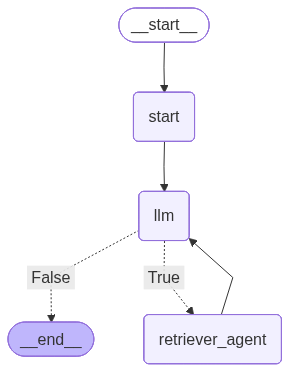

In [ ]:
from IPython.display import Image , display
display(Image(rag_agent.get_graph().draw_mermaid_png()))


In [ ]:
def running_agent():
  print("\n===RAG Agent===")
  while True:
    user_input = input("\n What is your question: ")
    if user_input.lower() in ['exit','quit']:
      break

    messages = [HumanMessage(content = user_input)]
    result = rag_agent.invoke({"messages" : messages})

    print("\n===ANSWER===")
    print(result['messages'][-1].content)